# Experiment 01

**Dataset (train prototypes):** WildGuardMix (5000 samples from train) \
**Dataset (eval):** WildGuardMix test \
**Model:** Bielik-1.5B \
**Layer:** Last block, mlp_proj \
**Sequence aggregation type:** Last Token


1. Import a dataset from HF
2. Import a small LLM
3. Collect activations on the whole dataset and at least 1 layer
5. Train LPM (by calculating 2 prototypes)
6. Think about saving/moving those trained values, so that they can be later used in inference
7. Think about saving metadata such as: what was the model, what was the dataset, what was the layer, so that we don't try to use those trained values in a wrong way.

## Setup & Imports

In [4]:
%load_ext autoreload
%autoreload 2

from datetime import datetime
from dotenv import load_dotenv
import os
import torch
from pathlib import Path
from amber.datasets import ClassificationDataset, TextDataset
from amber.datasets.loading_strategy import LoadingStrategy
from amber.store.local_store import LocalStore
from amber.language_model.language_model import LanguageModel


print("✅ Imports completed")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✅ Imports completed
✅ Imports completed


In [18]:
# Dataset configuration
DATASET_REPO_ID = "allenai/wildguardmix"
CONFIG_NAME = "wildguardtrain"
SPLIT = "train"
LOADING_STRATEGY = LoadingStrategy.MEMORY
CATEGORY_NAME = "prompt_harm_label"

# Store configuration
STORE_DIR = Path("store")
STORE_DIR.mkdir(parents=True, exist_ok=True)
LIMIT = 5000 # Number of samples to use

# Model configuration
MODEL_ID = "sshleifer/tiny-gpt2"  # Small model for quick experimentation

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if torch.cuda.is_available() else None  # Use half precision on GPU

# Training configuration
BATCH_SIZE_SAVE = 16 # Batch size for saving activations


load_dotenv(".env")

print(f"📊 Dataset: {DATASET_REPO_ID}")
print(f"📁 Config: {CONFIG_NAME}")
print(f"📁 Split: {SPLIT}")
print(f"📁 Store directory: {STORE_DIR}")
print(f"🔧 Loading strategy: {LOADING_STRATEGY}")
print(f"🔧 Model: {MODEL_ID}")
print(f"📱 Using device: {DEVICE}")
print()

STORE_DIR.mkdir(parents=True, exist_ok=True)
print("✅ Output directories created")


📊 Dataset: allenai/wildguardmix
📁 Config: wildguardtrain
📁 Split: train
📁 Store directory: store
🔧 Loading strategy: LoadingStrategy.MEMORY
🔧 Model: sshleifer/tiny-gpt2
📱 Using device: cpu

✅ Output directories created


## Load dataset

In [ ]:
print(f"📥 Loading {DATASET_REPO_ID} as classification dataset...")
store = LocalStore(STORE_DIR)
dataset = ClassificationDataset.from_huggingface(
    repo_id=DATASET_REPO_ID,
    store=store,
    split=SPLIT,
    loading_strategy=LOADING_STRATEGY,
    text_field="prompt",
    category_field=CATEGORY_NAME,
    limit=LIMIT,
    name=CONFIG_NAME,
)

print(f"✅ Dataset loaded successfully!")
print(f"📊 Number of samples: {len(dataset)}")
print(f"🏷️  Categories: {dataset.get_categories()}")


📥 Loading allenai/wildguardmix as classification dataset...


Using the latest cached version of the dataset since allenai/wildguardmix couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'wildguardtrain' at /Users/hubert/.cache/huggingface/datasets/allenai___wildguardmix/wildguardtrain/0.0.0/d29c47f41c8b51348b5c8e8c81c039b3132b66d1 (last modified on Wed Nov 19 11:39:24 2025).
Found the latest cached dataset configuration 'wildguardtrain' at /Users/hubert/.cache/huggingface/datasets/allenai___wildguardmix/wildguardtrain/0.0.0/d29c47f41c8b51348b5c8e8c81c039b3132b66d1 (last modified on Wed Nov 19 11:39:24 2025).
Saving the dataset (1/1 shards): 100%|██████████| 5000/5000 [00:00<00:00, 504596.14 examples/s]

✅ Dataset loaded successfully!
📊 Number of samples: 5000
🏷️  Categories: ['harmful', 'unharmful']


## Load model

In [7]:
print("📥 Loading language model...")

# Load model first to get model_id
lm = LanguageModel.from_huggingface(MODEL_ID, store=store)
lm.model.to(DEVICE)

# Create model-specific directory for organizing all files
MODEL_DIR = STORE_DIR / lm.model_id

# Set the store we want to use (overrides default)
lm.context.store = store

print("🔍 Available layers:")
lm.layers.print_layer_names()
print(f"✅ Model loaded: {lm.model_id}")
print(f"📁 Model directory: {MODEL_DIR}")
print(f"📁 Store location: {lm.context.store.base_path}")

📥 Loading language model...
🔍 Available layers:
gpt2lmheadmodel_transformer: No weight
gpt2lmheadmodel_transformer_wte: torch.Size([50257, 2])
gpt2lmheadmodel_transformer_wpe: torch.Size([1024, 2])
gpt2lmheadmodel_transformer_drop: No weight
gpt2lmheadmodel_transformer_h: No weight
gpt2lmheadmodel_transformer_h_0: No weight
gpt2lmheadmodel_transformer_h_0_ln_1: torch.Size([2])
gpt2lmheadmodel_transformer_h_0_attn: No weight
gpt2lmheadmodel_transformer_h_0_attn_c_attn: torch.Size([2, 6])
gpt2lmheadmodel_transformer_h_0_attn_c_proj: torch.Size([2, 2])
gpt2lmheadmodel_transformer_h_0_attn_attn_dropout: No weight
gpt2lmheadmodel_transformer_h_0_attn_resid_dropout: No weight
gpt2lmheadmodel_transformer_h_0_ln_2: torch.Size([2])
gpt2lmheadmodel_transformer_h_0_mlp: No weight
gpt2lmheadmodel_transformer_h_0_mlp_c_fc: torch.Size([2, 8])
gpt2lmheadmodel_transformer_h_0_mlp_c_proj: torch.Size([8, 2])
gpt2lmheadmodel_transformer_h_0_mlp_act: No weight
gpt2lmheadmodel_transformer_h_0_mlp_dropout: 

In [8]:
def get_model_size_mb(model):
    total_params = sum(p.numel() for p in model.parameters())
    param_size = sum(p.element_size() * p.numel() for p in model.parameters())
    buffer_size = sum(b.element_size() * b.numel() for b in model.buffers())
    total_size = param_size + buffer_size
    return total_size / (1024 ** 2)  # MB

print(f"Model size in RAM: {get_model_size_mb(lm.model):.2f} MB")

Model size in RAM: 2.39 MB


In [10]:
RUN_ID = f"LPM_tinygpt2_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

SAE_MODEL_PATH = MODEL_DIR / "testmodel.pt"
METADATA_PATH = MODEL_DIR / "training_metadata.json"
LAYER_SIGNATURE = 'gpt2lmheadmodel_transformer_h_1_mlp_c_proj'  # Attention layer (better activations)
# TODO: fill with actual relevant data

## Save activations

In [11]:
print("💾 Saving activations...")

# Use the store that was set on the language model
lm.activations.save_activations_dataset(
    dataset,
    layer_signature=LAYER_SIGNATURE,
    run_name=RUN_ID,
    batch_size=BATCH_SIZE_SAVE,
    autocast=False,  # Disable autocast for consistency
)

batches = lm.context.store.list_run_batches(RUN_ID)
print(f"✅ Saved {len(batches)} batches of activations")
print(f"📁 Run ID: {RUN_ID}")
print(f"📁 Store location: {lm.context.store.base_path}")

💾 Saving activations...
✅ Saved 313 batches of activations
📁 Run ID: LPM_tinygpt2_training_20251126_123419
📁 Store location: store
✅ Saved 313 batches of activations
📁 Run ID: LPM_tinygpt2_training_20251126_123419
📁 Store location: store


## tSNE/UMAP for save vs. unsafe activations

#### Option 1: Flatten

Processing batch: 1
Batch data type: <class 'dict'>
dict_keys(['activations'])
torch.Size([16, 56, 2])
torch.Size([56, 2])
Processing batch: 2
Batch data type: <class 'dict'>
dict_keys(['activations'])
torch.Size([16, 57, 2])
torch.Size([57, 2])
Processing batch: 3
Batch data type: <class 'dict'>
dict_keys(['activations'])
torch.Size([16, 55, 2])
torch.Size([55, 2])
tensor([[-4.1582e-04, -9.9770e-04],
        [ 4.5081e-04,  1.0685e-03],
        [-4.1898e-04, -1.0053e-03],
        [-4.2549e-04, -1.0211e-03],
        [-4.2292e-04, -1.0149e-03],
        [ 4.5078e-04,  1.0684e-03],
        [-1.1571e-04, -2.7634e-04],
        [ 4.5551e-04,  1.0796e-03],
        [-3.1669e-04, -7.5865e-04],
        [-2.8046e-04, -6.7149e-04],
        [ 4.5404e-04,  1.0761e-03],
        [ 9.2176e-05,  2.1949e-04],
        [-2.6075e-04, -6.2412e-04],
        [ 4.5269e-04,  1.0729e-03],
        [-4.1328e-04, -9.9156e-04],
        [-3.5346e-04, -8.4724e-04],
        [ 4.4887e-04,  1.0639e-03],
        [-3.8269e-0

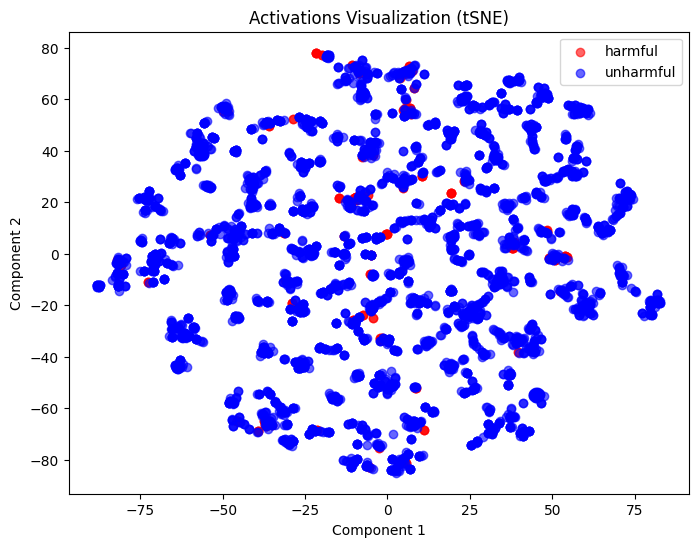

In [27]:
# Visualize activations with tSNE/UMAP colored by category (pad/truncate for equal shape)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False

# Load activations from LocalStore
batches = lm.context.store.list_run_batches(RUN_ID)

batch_data = lm.context.store.get_run_batch(RUN_ID, 1)
print(f"Processing batch: {1}")
print(f"Batch data type: {type(batch_data)}")
print(batch_data.keys())
print(batch_data['activations'].shape)
print(batch_data['activations'][0].shape)

batch_data = lm.context.store.get_run_batch(RUN_ID, 2)
print(f"Processing batch: {2}")
print(f"Batch data type: {type(batch_data)}")
print(batch_data.keys())
print(batch_data['activations'].shape)
print(batch_data['activations'][0].shape)

batch_data = lm.context.store.get_run_batch(RUN_ID, 3)
print(f"Processing batch: {3}")
print(f"Batch data type: {type(batch_data)}")
print(batch_data.keys())
print(batch_data['activations'].shape)
print(batch_data['activations'][0].shape)

print(batch_data['activations'][0])

activations = []
for batch in batches:
    batch_data = lm.context.store.get_run_batch(RUN_ID, batch)

    if isinstance(batch_data, dict) and 'activations' in batch_data:
        acts = batch_data['activations'].cpu().numpy()
        if acts.ndim == 2:
            activations.extend([a.flatten() for a in acts])
        else:
            activations.extend([a.flatten() for a in acts])
    elif isinstance(batch_data, list):
        activations.extend([t.cpu().numpy().flatten() for t in batch_data])
    else:
        raise ValueError("Unknown batch data format for activations.")

# Pad/truncate activations to the same length
max_len = max(a.shape[0] for a in activations)
min_len = min(a.shape[0] for a in activations)
target_len = min_len  # Use shortest for safety (or max_len for padding)
def pad_or_truncate(arr, length):
    if arr.shape[0] > length:
        return arr[:length]
    elif arr.shape[0] < length:
        return np.pad(arr, (0, length - arr.shape[0]), mode='constant')
    else:
        return arr

X = np.stack([pad_or_truncate(a, target_len) for a in activations], axis=0)
print(f"Padded/Truncated activations to shape: {X.shape}")
# Get categories from the dataset (assumes order matches activations)
categories = [item['category'] for item in dataset]
y = np.array(categories)[:len(X)]  # Ensure matching length

# Choose dimensionality reduction method
if UMAP_AVAILABLE:
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_embedded = reducer.fit_transform(X)
    method = 'UMAP'
else:
    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(X)
    method = 'tSNE'

# Plot
plt.figure(figsize=(8, 6))
colors = {'harmful': 'red', 'unharmful': 'blue'}
for cat in np.unique(y):
    idx = y == cat
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1],
                c=colors.get(cat, 'gray'), label=cat, alpha=0.6)
plt.title(f"Activations Visualization ({method})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

#### Option 2: Last Token

Processing batch: 0, last token activations shape: (16, 2)
Processing batch: 1, last token activations shape: (16, 2)
Processing batch: 2, last token activations shape: (16, 2)
Processing batch: 3, last token activations shape: (16, 2)
Processing batch: 4, last token activations shape: (16, 2)
Processing batch: 5, last token activations shape: (16, 2)
Processing batch: 6, last token activations shape: (16, 2)
Processing batch: 7, last token activations shape: (16, 2)
Processing batch: 8, last token activations shape: (16, 2)
Processing batch: 9, last token activations shape: (16, 2)
Processing batch: 10, last token activations shape: (16, 2)
Processing batch: 11, last token activations shape: (16, 2)
Processing batch: 12, last token activations shape: (16, 2)
Processing batch: 13, last token activations shape: (16, 2)
Processing batch: 14, last token activations shape: (16, 2)
Processing batch: 15, last token activations shape: (16, 2)
Processing batch: 16, last token activations shape

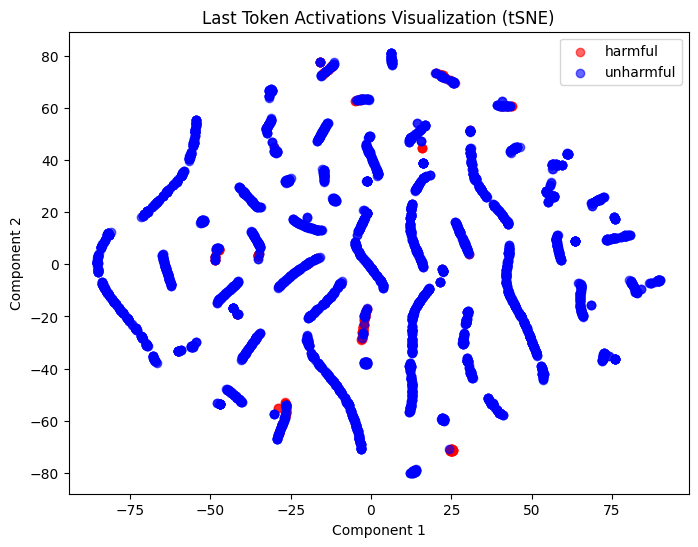

In [ ]:
# Visualize last token activations with tSNE/UMAP colored by category
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False

# Load activations from LocalStore
batches = lm.context.store.list_run_batches(RUN_ID)
last_token_activations = []
for batch in batches:
    batch_data = lm.context.store.get_run_batch(RUN_ID, batch)
    if isinstance(batch_data, dict) and 'activations' in batch_data:
        acts = batch_data['activations'].cpu().numpy()  # [batch_size, seq_len, d_model]
        last_acts = acts[:, -1, :]  # Take last token for each sample
        print(f"Processing batch: {batch}, last token activations shape: {last_acts.shape}")
        last_token_activations.append(last_acts)
    elif isinstance(batch_data, list):
        # If list, assume each item is [seq_len, d_model]
        last_acts = np.array([t.cpu().numpy()[-1] for t in batch_data])
        last_token_activations.append(last_acts)
    else:
        raise ValueError("Unknown batch data format for activations.")

print(f"Last token activations len: ", len(last_token_activations))
X = np.concatenate(last_token_activations, axis=0)  # [num_samples, d_model]
print(f"After concatenation, shape: {X.shape}")

# Get categories from the dataset (assumes order matches activations)
categories = [item['category'] for item in dataset]
y = np.array(categories)[:len(X)]  # Ensure matching length

# Choose dimensionality reduction method
if UMAP_AVAILABLE:
    reducer = umap.UMAP(n_components=2, random_state=42)
    X_embedded = reducer.fit_transform(X)
    method = 'UMAP'
else:
    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(X)
    method = 'tSNE'

# Plot
plt.figure(figsize=(8, 6))
colors = {'harmful': 'red', 'unharmful': 'blue'}
for cat in np.unique(y):
    idx = y == cat
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1],
                c=colors.get(cat, 'gray'), label=cat, alpha=0.6)
plt.title(f"Last Token Activations Visualization ({method})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

#### Option 3: Try direct (2 dimensions only)

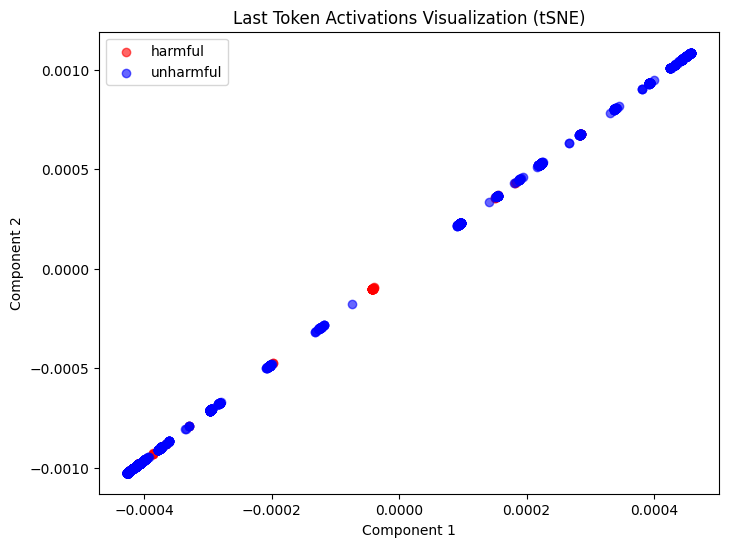

In [ ]:
# Visualize last token activations with tSNE/UMAP colored by category
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False

# Load activations from LocalStore
batches = lm.context.store.list_run_batches(RUN_ID)
last_token_activations = []
for batch in batches:
    batch_data = lm.context.store.get_run_batch(RUN_ID, batch)
    if isinstance(batch_data, dict) and 'activations' in batch_data:
        acts = batch_data['activations'].cpu().numpy()  # [batch_size, seq_len, d_model]
        last_acts = acts[:, -1, :]  # Take last token for each sample
        last_token_activations.append(last_acts)
    elif isinstance(batch_data, list):
        # If list, assume each item is [seq_len, d_model]
        last_acts = np.array([t.cpu().numpy()[-1] for t in batch_data])
        last_token_activations.append(last_acts)
    else:
        raise ValueError("Unknown batch data format for activations.")

X = np.concatenate(last_token_activations, axis=0)  # [num_samples, d_model]

# Get categories from the dataset (assumes order matches activations)
categories = [item['category'] for item in dataset]
y = np.array(categories)[:len(X)]  # Ensure matching length

# Plot directly (2 dimensions only)
plt.figure(figsize=(8, 6))
colors = {'harmful': 'red', 'unharmful': 'blue'}
for cat in np.unique(y):
    idx = y == cat
    plt.scatter(X[idx, 0], X[idx, 1],
                c=colors.get(cat, 'gray'), label=cat, alpha=0.6)
plt.title(f"Last Token Activations Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()

Bug?

In [33]:
import numpy as np
a = np.corrcoef(X[:,0], X[:,1])[0,1]
print("corr dim0/dim1:", a)

# Fit linear regression X1 = alpha * X0 + beta
alpha, beta = np.polyfit(X[:,0], X[:,1], 1)
print("linear fit: dim1 = %.4f * dim0 + %.4f" % (alpha, beta))

corr dim0/dim1: 0.9999971275735776
linear fit: dim1 = 2.3874 * dim0 + -0.0000


## Safe & harmful prototype calculation

In [20]:
import torch
import numpy as np

print("🧮 Calculating prototypes...")

harmful_acts = []
unharmful_acts = []

# Iterate through batches to collect last token activations
batches = lm.context.store.list_run_batches(RUN_ID)
current_idx = 0

for batch_id in batches:
    batch_data = lm.context.store.get_run_batch(RUN_ID, batch_id)
    
    if isinstance(batch_data, dict) and 'activations' in batch_data:
        acts = batch_data['activations'] # [batch_size, seq_len, d_model]
        # Strategy: Last Token
        current_batch_acts = acts[:, -1, :] 
        batch_size = current_batch_acts.shape[0]
    elif isinstance(batch_data, list):
        # List of tensors
        current_batch_acts = torch.stack([t[-1] for t in batch_data])
        batch_size = len(batch_data)
    else:
        print(f"Skipping batch {batch_id} due to unknown format")
        continue

    # Get categories for this batch
    # We assume the store saved them in the same order as the dataset
    batch_indices = range(current_idx, current_idx + batch_size)
    # Accessing dataset items. Since it's in memory, this should be fast.
    batch_categories = [dataset[i][CATEGORY_NAME] for i in batch_indices]
    
    # Separate by category
    for act, category in zip(current_batch_acts, batch_categories):
        if category == 'harmful':
            harmful_acts.append(act)
        elif category == 'unharmful':
            unharmful_acts.append(act)
            
    current_idx += batch_size

# Stack and calculate mean
if harmful_acts:
    harmful_tensor = torch.stack(harmful_acts)
    harmful_prototype = harmful_tensor.mean(dim=0)
    print(f"🔴 Harmful prototype calculated (from {len(harmful_acts)} samples)")
else:
    print("⚠️ No harmful samples found")
    harmful_prototype = None

if unharmful_acts:
    unharmful_tensor = torch.stack(unharmful_acts)
    unharmful_prototype = unharmful_tensor.mean(dim=0)
    print(f"🔵 Unharmful prototype calculated (from {len(unharmful_acts)} samples)")
else:
    print("⚠️ No unharmful samples found")
    unharmful_prototype = None

print("\nPrototypes:")
if harmful_prototype is not None:
    print("Harmful Prototype:")
    print(harmful_prototype)
if unharmful_prototype is not None:
    print("Unharmful Prototype:")
    print(unharmful_prototype)

🧮 Calculating prototypes...
🔴 Harmful prototype calculated (from 300 samples)
🔵 Unharmful prototype calculated (from 4700 samples)

Prototypes:
Harmful Prototype:
tensor([0.0005, 0.0011])
Unharmful Prototype:
tensor([0.0004, 0.0007])


### Suggestions for saving prototypes

To use these prototypes for later inference (e.g., for steering or classification), you should save them in a persistent format. Here are a few options:

1.  **PyTorch `.pt` file**: Simple and standard for PyTorch tensors.
    ```python
    prototypes = {
        'harmful': harmful_prototype,
        'unharmful': unharmful_prototype,
        'layer': LAYER_SIGNATURE,
        'model': MODEL_ID
    }
    torch.save(prototypes, MODEL_DIR / "prototypes.pt")
    ```

2.  **Safetensors**: If you plan to share weights or want faster loading/saving without pickle risks.
    ```python
    from safetensors.torch import save_file
    tensors = {
        'harmful': harmful_prototype,
        'unharmful': unharmful_prototype
    }
    save_file(tensors, MODEL_DIR / "prototypes.safetensors")
    ```

3.  **JSON (if converted to list)**: Not recommended for large vectors due to size and precision loss, but human-readable.

**Recommendation:** Use `torch.save` for internal experiments as it preserves the tensor properties (device, dtype) and allows saving metadata easily in the same dictionary.


In [23]:
# Save prototypes using torch.save (Recommended)
PROTOTYPES_PATH = Path("results") / RUN_ID / "prototypes.pt"

os.makedirs(PROTOTYPES_PATH.parent, exist_ok=True)

prototypes_data = {
    'harmful': harmful_prototype,
    'unharmful': unharmful_prototype,
    'metadata': {
        'layer': LAYER_SIGNATURE,
        'model': MODEL_ID,
        'dataset': DATASET_REPO_ID,
        'run_id': RUN_ID,
        'seq_strategy': 'last_token'
    }
}

if harmful_prototype is not None and unharmful_prototype is not None:
    torch.save(prototypes_data, PROTOTYPES_PATH)
    print(f"✅ Prototypes saved to: {PROTOTYPES_PATH}")
else:
    print("❌ Skipping save: Prototypes incomplete")

✅ Prototypes saved to: results/LPM_tinygpt2_training_20251126_123419/prototypes.pt
